# ResNet Model

In [2]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet10():
    return ResNet(BasicBlock, [1,1,1,1])

def ResNet12():
    return ResNet(BasicBlock, [1,2,1,1])

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()


# Modifoed ResNet

In [3]:
# Define the Basic Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, skip_kernel_size=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=skip_kernel_size, stride=stride, padding=skip_kernel_size//2, bias=False) \
            if in_channels != out_channels or stride != 1 else nn.Identity()
        
    def forward(self, x):
        residual = self.skip(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)
# Define the Custom ResNet-18 Architecture
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=10, block=ResidualBlock, layers=[2, 2, 2, 2], channels=[48, 96, 192, 320], kernel_size=3, skip_kernel_size=1, pool_size=4):
        super(CustomResNet18, self).__init__()
        
        self.in_channels = channels[0]
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        
        # Residual Layers
        self.layer1 = self.make_layer(block, channels[0], layers[0], stride=1, kernel_size=kernel_size, skip_kernel_size=skip_kernel_size)
        self.layer2 = self.make_layer(block, channels[1], layers[1], stride=2, kernel_size=kernel_size, skip_kernel_size=skip_kernel_size)
        self.layer3 = self.make_layer(block, channels[2], layers[2], stride=2, kernel_size=kernel_size, skip_kernel_size=skip_kernel_size)
        self.layer4 = self.make_layer(block, channels[3], layers[3], stride=2, kernel_size=kernel_size, skip_kernel_size=skip_kernel_size)
        
        # Average Pool and Fully Connected Layer
        self.avg_pool = nn.AvgPool2d(kernel_size=pool_size)
        self.fc = nn.Linear(channels[3], num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride, kernel_size, skip_kernel_size):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, kernel_size, skip_kernel_size))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Pre_Activation ResNet Model

In [4]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def PreActResNet10():
    return PreActResNet(PreActBlock, [1,1,1,1])

def PreActResNet12():
    return PreActResNet(PreActBlock, [1,2,1,1])

def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])

def PreActResNet34():
    return PreActResNet(PreActBlock, [3,4,6,3])

def PreActResNet50():
    return PreActResNet(PreActBottleneck, [3,4,6,3])

def PreActResNet101():
    return PreActResNet(PreActBottleneck, [3,4,23,3])

def PreActResNet152():
    return PreActResNet(PreActBottleneck, [3,8,36,3])


def test():
    net = PreActResNet18()
    y = net((torch.randn(1,3,32,32)))
    print(y.size())

# test()


# Wide ResNet

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    """
    Creates a 3x3 convolution with the specified stride and zero padding.
    Used frequently in Wide ResNet blocks.
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3,
                     stride=stride, padding=1, bias=False)

class WideBasicBlock(nn.Module):
    """
    A basic residual block used in Wide ResNet.
    It includes two 3x3 convolutions with optional dropout in between.
    """
    def __init__(self, in_planes, out_planes, stride=1, dropout_rate=0.0):
        super(WideBasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, out_planes, stride)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes, stride=1)

        # Used to match dimensions if stride != 1 or channel sizes differ
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1,
                          stride=stride, bias=False)
            )

        # Store dropout rate for usage in forward
        self.dropout_rate = dropout_rate

    def forward(self, x):
        # First transform
        out = F.relu(self.bn1(x), inplace=True)
        if self.dropout_rate > 0:
            out = F.dropout(out, p=self.dropout_rate, training=self.training)
        out = self.conv1(out)

        # Second transform
        out = F.relu(self.bn2(out), inplace=True)
        if self.dropout_rate > 0:
            out = F.dropout(out, p=self.dropout_rate, training=self.training)
        out = self.conv2(out)

        # Add the shortcut connection
        out += self.shortcut(x)
        return out

class WideResNet(nn.Module):
    """
    A Wide ResNet implementation allowing for a floating-point widen_factor
    and dropout within the residual blocks.

    depth: total number of layers (must satisfy (depth - 4) % 6 == 0).
    widen_factor: scales the number of output channels in each block.
    num_classes: number of output classes (default 10 for CIFAR-10).
    dropout_rate: dropout probability applied inside each WideBasicBlock.
    """
    def __init__(self, depth, widen_factor, num_classes=10, dropout_rate=0.0):
        super(WideResNet, self).__init__()
        # Check the standard WRN condition
        assert (depth - 4) % 6 == 0, "For WideResNet, (depth - 4) must be divisible by 6."
        n = (depth - 4) // 6

        # Initial convolution: 3 -> 16 channels
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)

        # Compute channel sizes after multiplying by widen_factor
        ch1 = int(16 * widen_factor)
        ch2 = int(32 * widen_factor)
        ch3 = int(64 * widen_factor)

        # Create three stages of residual blocks
        self.layer1 = self._make_layer(ch1, n, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(ch2, n, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(ch3, n, stride=2, dropout_rate=dropout_rate)

        # Final batch normalization before pooling
        self.bn = nn.BatchNorm2d(ch3)

        # Fully connected layer
        self.linear = nn.Linear(ch3, num_classes)

    def _make_layer(self, out_planes, num_blocks, stride, dropout_rate):
        """
        Creates a stage (sequential) of num_blocks WideBasicBlocks.
        The first block may downsample spatially if stride=2.
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(WideBasicBlock(self.in_planes, out_planes, s, dropout_rate))
            self.in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution
        out = self.conv1(x)

        # Three residual stages
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # Batch norm + ReLU
        out = F.relu(self.bn(out), inplace=True)

        # Global average pooling: turn HxW into 1x1
        out = F.avg_pool2d(out, out.size(2))

        # Flatten and linear classifier
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def wrn(depth=28, widen_factor=3.7, num_classes=10, dropout_rate=0.0):
    """
    Build a WideResNet model with the given depth, widen factor, class count,
    and optional dropout in the residual blocks.
    """
    return WideResNet(depth=depth, widen_factor=widen_factor,
                      num_classes=num_classes, dropout_rate=dropout_rate)


# -----------------------
# Example usage:
# model = wrn(depth=40, widen_factor=10, num_classes=10, dropout_rate=0.3)
# x = torch.randn(8, 3, 32, 32)  # e.g., mini-batch for CIFAR-10
# y = model(x)  # forward pass


# Model Parameters num

In [6]:
import torch
# from utils import progress_bar
from torchsummary import summary

model = wrn()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  

summary(model, input_size=(3,32, 32)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 59, 32, 32]           8,496
       BatchNorm2d-4           [-1, 59, 32, 32]             118
            Conv2d-5           [-1, 59, 32, 32]          31,329
            Conv2d-6           [-1, 59, 32, 32]             944
    WideBasicBlock-7           [-1, 59, 32, 32]               0
       BatchNorm2d-8           [-1, 59, 32, 32]             118
            Conv2d-9           [-1, 59, 32, 32]          31,329
      BatchNorm2d-10           [-1, 59, 32, 32]             118
           Conv2d-11           [-1, 59, 32, 32]          31,329
   WideBasicBlock-12           [-1, 59, 32, 32]               0
      BatchNorm2d-13           [-1, 59, 32, 32]             118
           Conv2d-14           [-1, 59,

# Check Data

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
10000


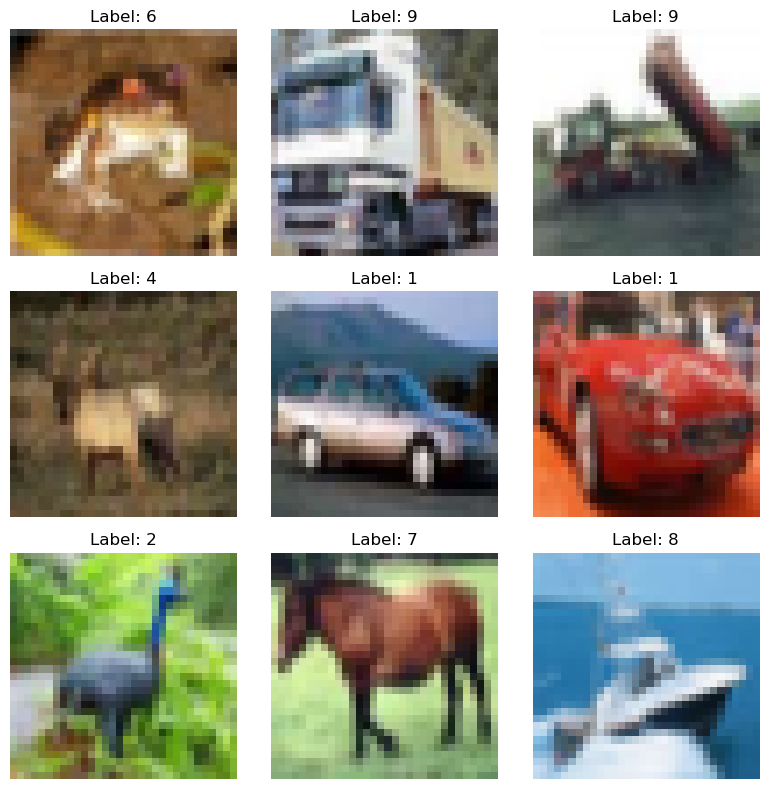

In [7]:
# Check Data
import pickle
import numpy as np
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle("deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1" )
print(data.keys())  
print(len(data[b'labels']))
images = data[b'data']
labels = data[b'labels']
import matplotlib.pyplot as plt
images = images.reshape(-1, 3, 32, 32)  # N=10000

# 4) Display a few example images
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    # Each image is now of shape (3, 32, 32).
    # For matplotlib, transpose to (32, 32, 3).
    img = np.transpose(images[i], (1, 2, 0))

    plt.imshow(img)
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Load Data
two transformers for train data, 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import os
from PIL import Image
import multiprocessing
from torch.utils.data import random_split


# Unpickle function
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class CIFARDataset(Dataset):
    def __init__(self, data_files, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for file in data_files:
            batch = unpickle(file)
            images = batch[b'data']
            labels = batch[b'labels']

            images = images.reshape(-1, 3, 32, 32).astype(np.uint8)  # Keep uint8 (0-255)
            self.data.append(images)
            self.labels.extend(labels)

        self.data = np.vstack(self.data)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]  # Still a NumPy array (H, W, C)
        label = self.labels[idx]

        # Convert NumPy array to PIL image before applying transforms
        image = Image.fromarray(np.transpose(image, (1, 2, 0)))  # Convert (C, H, W) -> (H, W, C)
        
        if self.transform:
            image = self.transform(image)  # Now transform works correctly

        return image, label




# Define paths
# data_dir = ""  # Change this if your path is different
data_dir = "deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py" 
train_files = [os.path.join(data_dir, f"data_batch_{i}") for i in range(1, 6)]
test_file = os.path.join(data_dir, "test_batch")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop 32x32 with padding of 4
    transforms.RandomHorizontalFlip(),  # Flip the image horizontally with 50% probability
    transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # Convert image to a PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalize with CIFAR-10 mean/std
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
])

# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

"""
Q: Do we need trans-test?

"""
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Automatically determine optimal num_workers
num_workers = min(8, multiprocessing.cpu_count() // 2)  # Use half of CPU cores, max 8
pin_memory = True if torch.cuda.is_available() else False  # Enable only if using GPU



# Load datasets
train_dataset = CIFARDataset(train_files, transform=transform_train)
test_dataset = CIFARDataset([test_file], transform=transform_test)

train_size = int(0.9 * len(train_dataset))  
val_size = len(train_dataset) - train_size 
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)



In [9]:
# Check Data
# data = unpickle("deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1" )
# print(data.keys())  
# print(len(data[b'labels']))

# Model Initialization

In [10]:
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize model
# model = CustomResNet18().to(device)
###

# for student
#model = wrn(depth=28, widen_factor=3.7, num_classes=10,dropout_rate=0.0).to(device)

###


model = wrn(depth=40, widen_factor=10, num_classes=10,dropout_rate=0.3).to(device)


# summary(model, input_size=(3,32, 32)) 
# Training function with validation
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=200, patience=10, save_dir="checkpoints"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    best_val_acc = 0.0  # Store the best validation accuracy
    early_stop_counter = 0  # Early stopping counter
    best_val_loss = float("inf") 

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        scheduler.step()  # Update learning rate

        # Compute training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Compute validation loss and accuracy
        val_loss, val_acc = validate(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # # Save the best model based on validation accuracy
        # if val_acc > best_val_acc:
        #     best_val_acc = val_acc
        #     torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        #     print("Best model saved!")

        # # Early stopping logic
        # if val_loss > train_loss:
        #     early_stop_counter += 1
        #     if early_stop_counter >= patience:
        #         print("Early stopping triggered!")
        #         break

        # --- Save the best model based on val_acc ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
            print(f"Best model saved (based on val_acc = {val_acc:.2f}%)!")

        # --- Early Stopping based on val_loss ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered! Validation loss did not improve.")
                break

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    model.train()  # Switch back to training mode
    return avg_val_loss, val_acc

# Test function
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


# Set hyperparameters
"""
when epochs = 350
warmup_total_iters = 10
"""
epochs = 350
warmup_total_iters = 10
patience = 2000  # Number of epochs to wait before early stopping
save_dir = "checkpoints"

# Define loss function
criterion = nn.CrossEntropyLoss()
# Define optimizer

# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define learning rate scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Learning rate scheduler with warmup
warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_total_iters)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=epochs-warmup_total_iters)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[5])


# Train the model
train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience, save_dir)

# Test the model
test(model, test_loader)


cuda
Epoch 1/350, Train Loss: 1.7921, Train Acc: 32.35%, Val Loss: 1.8394, Val Acc: 35.12%
Best model saved (based on val_acc = 35.12%)!
Epoch 2/350, Train Loss: 1.3783, Train Acc: 49.72%, Val Loss: 1.6027, Val Acc: 46.96%
Best model saved (based on val_acc = 46.96%)!
Epoch 3/350, Train Loss: 1.1693, Train Acc: 58.05%, Val Loss: 1.3213, Val Acc: 55.34%
Best model saved (based on val_acc = 55.34%)!
Epoch 4/350, Train Loss: 1.0450, Train Acc: 62.90%, Val Loss: 1.0991, Val Acc: 61.20%
Best model saved (based on val_acc = 61.20%)!


/home/chungmop/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5/350, Train Loss: 0.9483, Train Acc: 66.60%, Val Loss: 1.2025, Val Acc: 62.18%
Best model saved (based on val_acc = 62.18%)!
Epoch 6/350, Train Loss: 0.9533, Train Acc: 66.38%, Val Loss: 1.1562, Val Acc: 62.26%
Best model saved (based on val_acc = 62.26%)!
Epoch 7/350, Train Loss: 0.8321, Train Acc: 71.08%, Val Loss: 0.8705, Val Acc: 70.98%
Best model saved (based on val_acc = 70.98%)!
Epoch 8/350, Train Loss: 0.7690, Train Acc: 73.12%, Val Loss: 0.9008, Val Acc: 69.42%
Epoch 9/350, Train Loss: 0.7356, Train Acc: 74.44%, Val Loss: 0.8455, Val Acc: 71.28%
Best model saved (based on val_acc = 71.28%)!
Epoch 10/350, Train Loss: 0.6971, Train Acc: 75.87%, Val Loss: 0.7953, Val Acc: 73.38%
Best model saved (based on val_acc = 73.38%)!
Epoch 11/350, Train Loss: 0.6762, Train Acc: 76.63%, Val Loss: 0.7051, Val Acc: 76.10%
Best model saved (based on val_acc = 76.10%)!
Epoch 12/350, Train Loss: 0.6619, Train Acc: 77.09%, Val Loss: 0.7814, Val Acc: 73.30%
Epoch 13/350, Train Loss: 0.6490,

# Save Model

In [11]:
PreActResNet152_2_model = model

In [12]:
torch.save(PreActResNet152_2_model.state_dict(), "wideresnet.pth")

# Run Kaggal Test

In [13]:
import pickle
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# Load the test dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load the no-label test dataset
test_data = unpickle("deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/cifar_test_nolabel.pkl")

# Extract image data and IDs
test_images = test_data[b'data']  # Shape (N, 3072)
test_ids = test_data[b'ids']  # Image IDs for submission


In [14]:
test_images = test_images.transpose(0,3,1,2)
# test_images.shape

In [15]:
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt

# # -- 1) Load the test dataset (as you did) --
# def unpickle(file):
#     with open(file, 'rb') as fo:
#         dict_ = pickle.load(fo, encoding='bytes')
#     return dict_

# test_data = unpickle("deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/cifar_test_nolabel.pkl")

# # test_images has shape (N, 3072) by default, flattening each 32x32x3 image
# test_images = test_data[b'data']        # shape (N, 3072)
# test_ids = test_data[b'ids']           # IDs for each image

# # -- 2) Reshape: from (N, 3072) to (N, 3, 32, 32) --
# # test_images = test_images.reshape(-1, 3, 32, 32)
# test_images = test_images.transpose(0,3,1,2)

# # -- 3) Display a few images --
# plt.figure(figsize=(8, 8))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
    
#     # Each image here has shape (3, 32, 32).
#     # Transpose to (32, 32, 3) to show via plt.imshow:
#     img = np.transpose(test_images[i], (1, 2, 0))
    
#     plt.imshow(img)
#     plt.title(f"ID: {test_ids[i]}")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()


In [16]:

# Reshape to (N, 3, 32, 32)
# test_images = test_images.reshape(-1, 3, 32, 32).astype(np.uint8)
# test_images = test_images.transpose(0,3,2,1)
class TestCIFARDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.fromarray(np.transpose(image, (1, 2, 0)))  # Convert (C, H, W) → (H, W, C)

        if self.transform:
            image = self.transform(image)

        return image

# Define test transforms (same as training but without augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Create DataLoader for inference
test_dataset = TestCIFARDataset(test_images, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)


In [17]:
def run_inference(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():  # Disable gradients for faster inference
        for images in test_loader:
            images = images.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)  # Get the class index with max probability
            predictions.extend(predicted.cpu().numpy())  # Move to CPU for saving

    return predictions


In [18]:
import pandas as pd

# Run inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions = run_inference(model, test_loader, device)

# Create a DataFrame
submission_df = pd.DataFrame({'ID': test_ids, 'Labels': predictions})

# Save to CSV (without index column)
submission_df.to_csv("wideresnet250.csv", index=False)

print("Submission file saved as submission.csv")


Submission file saved as submission.csv
